In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

In [3]:
#Hyper-parameters
BUFFER_SIZE = 8#int(1e5)      #replay buffer size
BATCH_SIZE = 8#128             #minibatch size
GAMMA = 0.999                #discount factor
TAU = 1e-2#1e-1                  #for soft update of target parameters
LR = 1e-3                   #learning rate
TEST_EVERY = 1600            #how often to test the network
UPDATE_EVERY =1
eps_start = 1.0
eps_end = 0.5
eps_decay = 0.9981 #125e-6
PER_ALPHA = 0.6
PER_BETA = 0.4
PRIORITIZED_REPLAY = False

episodes = 6000 #3100 train, 500 test
seed = 0                    #random seed number
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inp_fptr = open("ricianch_variation.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]

In [4]:
print(ch_randvals[0])

#print(np.complex(ch_randvals[0].replace('i','j')))

(1.1128+0.0082264j)


Beamset: [(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)]
Bemset in deg: [(22.500000000000004, 8), (45.0, 8), (67.5, 8), (90.0, 8), (112.5, 8), (135.0, 8), (157.5, 8), (180.0, 8)]
Ntx: 8, active Ntx: 4, Beam: [ 0.35355339+0.j         -0.21414724-0.28132003j -0.09413548+0.34079101j
  0.32818294-0.13151411j -0.30342524-0.18147485j  0.03938632+0.3513527j
  0.25571266-0.24415371j -0.34915657-0.05558496j]


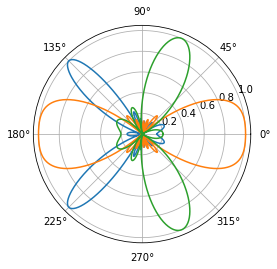

In [5]:
#Testing (beam_dir, beam_width) Beamset
from Source.antenna.ula import var_steervec
from Source.misc_fun.utils import Generate_Beams, var_plotbeam

width_vec = np.array([np.pi/8])
beamset = Generate_Beams(8,width_vec)

print("Beamset: {}".format(beamset))
print("Bemset in deg: {}".format([(x[0]*180/np.pi,x[1]) for x in beamset]))

tx_beam = var_steervec(8,beamset[5], 0)
print("Ntx: {}, active Ntx: {}, Beam: {}".format(8, 4, tx_beam))

theta, gr = var_plotbeam(beamset[5], 8)
theta2, gr2 = var_plotbeam(beamset[7], 8)
theta3, gr3 = var_plotbeam(beamset[2], 4)
ax = plt.subplot(111, projection='polar')
##print(theta.shape, gr.shape)
ax.plot(theta,gr, theta2, gr2, theta3,gr3)
plt.show()
    

In [6]:
#Choose the environment
em = EnvManager(device, 'combrf-v7', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)

#EPISODE length
min_episode_length = em.env.N_rx
max_episode_length = em.env.N_rx
episode_delta = 1

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 3500)

if PRIORITIZED_REPLAY:
    beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
if not PRIORITIZED_REPLAY:
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
else:
    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

uma-los
[]
QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=16, bias=True)
)


In [7]:
print("tx_locs: {}".format(em.env.tx_locs))

tx_locs: [array([[-300. , -300. ,   21.5]]), array([[-300. , -200. ,   21.5]]), array([[-300. , -100. ,   21.5]]), array([[-300. , -400. ,   21.5]]), array([[-300. , -500. ,   21.5]]), array([[-200. , -300. ,   21.5]]), array([[-200. , -200. ,   21.5]]), array([[-200. , -100. ,   21.5]]), array([[-200. , -400. ,   21.5]]), array([[-200. , -500. ,   21.5]]), array([[-100. , -300. ,   21.5]]), array([[-100. , -200. ,   21.5]]), array([[-100. , -100. ,   21.5]]), array([[-100. , -400. ,   21.5]]), array([[-100. , -500. ,   21.5]]), array([[-400. , -300. ,   21.5]]), array([[-400. , -200. ,   21.5]]), array([[-400. , -100. ,   21.5]]), array([[-400. , -400. ,   21.5]]), array([[-400. , -500. ,   21.5]]), array([[-500. , -300. ,   21.5]]), array([[-500. , -200. ,   21.5]]), array([[-500. , -100. ,   21.5]]), array([[-500. , -400. ,   21.5]]), array([[-500. , -500. ,   21.5]])]


In [8]:
print("Beamset: {}".format(em.env.BeamSet))

Beamset: [(0.19634954, 16) (0.39269908, 16) (0.58904862, 16) (0.78539816, 16)
 (0.9817477 , 16) (1.17809725, 16) (1.37444679, 16) (1.57079633, 16)
 (1.76714587, 16) (1.96349541, 16) (2.15984495, 16) (2.35619449, 16)
 (2.55254403, 16) (2.74889357, 16) (2.94524311, 16) (3.14159265, 16)]


## Test with random untrained actions

obs = em.env.reset(np.exp(1j * 2 * np.pi * 0.6),0)
#print(len(em.env.beamwidth_vec))
#print(em.env.action_space.n)
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done,_ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

In [9]:
print(em.env.sc_xyz)
print(em.env.ch_model)

[]
uma-los


In [10]:
from Source.misc_fun.channel_mmW import *
from Source.misc_fun.geometry import *
from Source.antenna import ula

def Compute_AvgError(em, device, policy_net, ch_randval, loc_errors):
    #loc_errors = []
    for tx_loc in em.env.tx_locs:
        tx_dir_ndx = 0
        norm_tx_xloc = np.array([(tx_loc[0][0]) / 1000])  
        norm_tx_yloc = np.array([(tx_loc[0][1]) / 1000])  
        norm_tx_zloc = np.array([(tx_loc[0][2]) / 22.5])
        norm_tx_ndx = np.array([tx_dir_ndx/ em.env.obs_space.nvec[3]])
        obs = np.array([np.concatenate((norm_tx_ndx, norm_tx_xloc, norm_tx_yloc, norm_tx_zloc), axis=0)])
        obs_tensor = torch.tensor(obs, device=device, dtype=torch.float32)
        policy_net.eval()
        with torch.no_grad():
            action_probs = policy_net(obs_tensor).detach().data.cpu().numpy()[0]  
        policy_net.train()
        best_rxdir_ndx= np.argsort(action_probs)[::-1][0]
        
        #compute dqn rate
        
        dbp = 4 * tx_loc[0, 2] * em.env.rx_loc[0, 2] * em.env.freq / em.env.c
        d_2d = np.linalg.norm(np.array([[tx_loc[0, 0], tx_loc[0, 1], 0]]) - np.array(
            [[em.env.rx_loc[0, 0], em.env.rx_loc[0, 1], 0]]))

        if(dbp <= d_2d <= 5e3) and (em.env.ch_model == 'uma-los'):
            ch_model = em.env.init_ch_model + '-dbp'
        else:
            ch_model = em.env.init_ch_model

        channel = Channel(em.env.freq, tx_loc, em.env.rx_loc, em.env.sc_xyz, 'model', ch_model, 'nrx', em.env.N_rx,
                               'ntx', em.env.N_tx, 'nFFT', em.env.nFFT, 'df', em.env.df)

        tx_num = em.env.get_txloc_ndx(tx_loc)
        channel.generate_paths(ch_randval, tx_num)
        h = channel.get_h()  # channel coefficient
    
        tx_bdir = em.env.BeamSet[tx_dir_ndx]
        tx_beam = ula.var_steervec(em.env.N_tx, tx_bdir, 0)
        rx_bdir =em.env.BeamSet[best_rxdir_ndx]                
        wRF = ula.var_steervec(em.env.N_rx, rx_bdir , 0)
        eff_ch = np.array(h[:,:,0]).dot(tx_beam)
        rssi_val = np.sqrt(em.env.N_rx*em.env.N_tx)*np.array(np.conj(wRF.T).dot(eff_ch)) #+ (np.conj(wRF.T).dot(self.noise))[0]
        Es = db2lin(em.env.P_tx)  # * (1e-3 / self.B)
        SNR = Es * np.abs(rssi_val) ** 2 / (em.env.N0 * em.env.B)
        dqn_rate = np.log2(1 + SNR)  # in Gbit/s (self.B / self.nFFT) *
        
        #compute exh rate
        max_rate = 0.0
        min_rate = 1e10
        max_action_ndx = 0
        min_action_ndx = 0
        max_rssi_val = 0
        min_rssi_val =0
        for rbdir_ndx in range(em.env.action_space.n):
            wRF = ula.var_steervec(em.env.N_rx, em.env.BeamSet[rbdir_ndx], 0)

            rssi_val = np.sqrt(em.env.N_rx * em.env.N_tx) * np.array(np.conj(wRF.T).dot(eff_ch)) #+ (np.conj(wRF.T).dot(self.noise))[0]
            Es = db2lin(em.env.P_tx)  # * (1e-3 / self.B)
            SNR = Es * np.abs(rssi_val) ** 2 / (em.env.N0 * em.env.B)
            rate = np.log2(1 + SNR)

            if rate > max_rate:
                max_rate = rate
                max_action_ndx = rbdir_ndx
                max_rssi_val = rssi_val

            if rate < min_rate:
                min_rate = rate
                min_action_ndx = rbdir_ndx
                min_rssi_val = rssi_val
        exh_rate = max_rate
        loc_errors.append(exh_rate-dqn_rate)
        
    return np.mean(loc_errors)

## Train the DQN agent

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
tx_loc:[[-200.  -400.    21.5]] not converged until episode: 1
Episode 1,	Score: 5.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 2, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 5.071712493896484

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
tx_loc:[[-300.  -400.    21.5]] not converged until episode: 2
Episode 2,	Score: 5.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 2, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 5.003763198852539

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
tx_loc:[[-200.  -200.    21.5]] not converged until episode: 3
Episode 3,	Score: 4.00, eps: 0.5, moving avg_rwd: 0.0, current_best action:

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
tx_loc:[[-100.  -400.    21.5]] not converged until episode: 25
Episode 25,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 2, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 2.0811543464660645

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [2, 1, 3, 0, 4, 15, 5, 14, 6, 13, 7, 12, 8, 11, 9, 10], prevep_bestaction: 2
Episode 26,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 1.859494924545288

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 27,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 2.021031141281128

TX Location: [[-400.  -500.    21.5]], Go

Episode 49,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 2.0358309745788574

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 50,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 2.009514331817627

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 51,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 13, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 2.035024642944336

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 52,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 13, ep_len: 16, TXloc: [[

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
tx_loc:[[-300.  -300.    21.5]] not converged until episode: 75
Episode 75,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 2.029892921447754

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
tx_loc:[[-500.  -200.    21.5]] not converged until episode: 76
Episode 76,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_best action: 10, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 2.0375943183898926

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
tx_loc:[[-500.  -500.    21.5]] not converged until episode: 77
Episode 77,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.0, current_

Episode 100,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 1.012181282043457

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-200.  -100.    21.5]] not converged until episode: 101
Episode 101,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 9, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 2.019946813583374

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 102,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 1.01304030418396

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction:

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 124,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4399999976158142, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 2.0057854652404785

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 125,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4399999976158142, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 2.0065877437591553

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 126,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4399999976158142, current_best action: 12, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 2.0201900005340576

TX Location: [[-200.  -200.    21.5]], Goal steps: 1

Episode 148,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 1.0068556070327759

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-400.  -200.    21.5]] not converged until episode: 149
Episode 149,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 12, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 2.0146615505218506

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 150,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 1.0068323612213135

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_be

Episode 172,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.3199999928474426, current_best action: 11, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 2.0108399391174316

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 173,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.3100000023841858, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 2.011104106903076

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 174,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3199999928474426, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 1.0138263702392578

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-400.  -100.    21.5]] not converged until e

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-200.  -500.    21.5]] not converged until episode: 196
Episode 196,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.30000001192092896, current_best action: 11, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 2.020289897918701

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 197,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.30000001192092896, current_best action: 14, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 2.0098607540130615

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-300.  -500.    21.5]] not converged until episode: 198
Episode 198,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.30000001192092896, current_best action

Episode 220,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.2800000011920929, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 1.0056648254394531

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-300.  -500.    21.5]] not converged until episode: 221
Episode 221,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.2800000011920929, current_best action: 11, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 2.0066933631896973

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-400.  -500.    21.5]] not converged until episode: 222
Episode 222,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.2800000011920929, current_best action: 11, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 2.0081350803375244

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: 

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 244,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.25999999046325684, current_best action: 9, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 2.008781671524048

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
tx_loc:[[-400.  -300.    21.5]] not converged until episode: 245
Episode 245,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.25, current_best action: 14, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 2.0093231201171875

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 246,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.25, current_best action: 11, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 2.008087635040283

TX Location: [[-4

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 268,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.23000000417232513, current_best action: 10, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 2.012455940246582

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 269,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.23999999463558197, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 1.010981798171997

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
tx_loc:[[-100.  -500.    21.5]] not converged until episode: 270
Episode 270,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.23000000417232513, current_best action: 10, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 2.04011

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 292,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.25999999046325684, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 1.009702444076538

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 293,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.27000001072883606, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 1.0088388919830322

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-100.  -500.    21.5]] not converged until episode: 294
Episode 294,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.27000001072883606, current_best action: 11, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 2.017

Episode 316,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.33000001311302185, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 1.0147427320480347

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-100.  -500.    21.5]] not converged until episode: 317
Episode 317,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.33000001311302185, current_best action: 9, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 2.0244967937469482

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 318,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3400000035762787, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 1.0146092176437378

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bes

Episode 340,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 2.043464422225952

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 341,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4099999964237213, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 1.043015480041504

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 342,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 9, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 2.09531307220459

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-400.  -300.    21.5]] not converged until episode:

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-200.  -400.    21.5]] not converged until episode: 366
Episode 366,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.41999998688697815, current_best action: 8, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 2.083113670349121

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-300.  -500.    21.5]] not converged until episode: 367
Episode 367,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4099999964237213, current_best action: 8, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 2.0578746795654297

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
tx_loc:[[-500.  -200.    21.5]] not converged until episode: 368
Episode 368,	Score: 0.00, eps: 0

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-200.  -200.    21.5]] not converged until episode: 390
Episode 390,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.41999998688697815, current_best action: 8, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 2.036344289779663

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-400.  -200.    21.5]] not converged until episode: 391
Episode 391,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.41999998688697815, current_best action: 11, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 2.054446220397949

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-200.  -100.    21.5]] not converged until episode: 392
Episode 392,	Score: 0.00, eps:

Episode 414,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 9, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 2.056609630584717

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-300.  -500.    21.5]] not converged until episode: 415
Episode 415,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 8, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 2.082041025161743

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 416,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.3799999952316284, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 2.0308942794799805

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestac

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 438,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3400000035762787, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 1.041780710220337

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-100.  -100.    21.5]] not converged until episode: 439
Episode 439,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.33000001311302185, current_best action: 12, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 2.0438461303710938

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 440,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3400000035762787, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 1.03233

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 462,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3499999940395355, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.0399432182312012

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-500.  -400.    21.5]] not converged until episode: 463
Episode 463,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.3400000035762787, current_best action: 11, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 2.118668556213379

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-200.  -500.    21.5]] not converged until episode: 464
Episode 464,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.3400000035762787, current_best action: 1

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-200.  -300.    21.5]] not converged until episode: 486
Episode 486,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.3400000035762787, current_best action: 9, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 2.051840305328369

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-200.  -300.    21.5]] not converged until episode: 487
Episode 487,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.33000001311302185, current_best action: 9, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 2.049009323120117

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-400.  -400.    21.5]] not converged until episode: 488
Episode 488,	Score: 0.00, eps: 0.

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 510,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.33000001311302185, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 1.0571345090866089

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 511,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3400000035762787, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 1.0285674333572388

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 512,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3499999940395355, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.0312203168869019

TX Location: [[-200.  -500.    21.5]], Goal steps: 

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 534,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 12, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 2.2722628116607666

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 535,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.0614047050476074

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 536,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 1.0930447578430176

TX Location: [[-100.  -100.    21.5]], Goal steps:

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 558,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 1.105184555053711

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 559,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 9, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 2.0695996284484863

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
tx_loc:[[-400.  -100.    21.5]] not converged until episode: 560
Episode 560,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 13, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 2.1755580

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 582,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.41999998688697815, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 1.102872371673584

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-100.  -400.    21.5]] not converged until episode: 583
Episode 583,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.41999998688697815, current_best action: 9, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 2.1361236572265625

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 584,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.41999998688697815, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 2.1160697

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-100.  -500.    21.5]] not converged until episode: 606
Episode 606,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4099999964237213, current_best action: 9, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 2.0541415214538574

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-500.  -100.    21.5]] not converged until episode: 607
Episode 607,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 12, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 2.1284382343292236

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-500.  -200.    21.5]] not converged until episode: 608
Episode 608,	Score: 0.00, eps:

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 630,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.3799999952316284, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 1.1023600101470947

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 631,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 1.0699549913406372

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 632,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 1.1181951761245728

TX Location: [[-500.  -200.    21.5]], Goal steps:

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 656,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4099999964237213, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 1.0857232809066772

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-400.  -100.    21.5]] not converged until episode: 657
Episode 657,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 12, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 2.185242176055908

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-300.  -500.    21.5]] not converged until episode: 658
Episode 658,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 8

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 680,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.38999998569488525, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.0722116231918335

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 681,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 1.1919533014297485

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 682,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4000000059604645, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 1.1957991123199463

TX Location: [[-300.  -300.    21.5]], Goal steps: 16

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 704,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.46000000834465027, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 1.2121281623840332

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-100.  -500.    21.5]] not converged until episode: 705
Episode 705,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.46000000834465027, current_best action: 9, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 2.1805009841918945

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 706,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4699999988079071, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 1.10871

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 730,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5099999904632568, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 1.1530065536499023

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 731,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5099999904632568, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 1.1575825214385986

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-100.  -400.    21.5]] not converged until episode: 732
Episode 732,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5, current_best action: 9, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 2.219295024871826

TX Loca

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-200.  -300.    21.5]] not converged until episode: 756
Episode 756,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5, current_best action: 11, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 2.206251621246338

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 757,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 2.7902326583862305

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 758,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5099999904632568, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 1.3844523429870605

TX Location: [[-30

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 782,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5299999713897705, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 1.351231336593628

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-100.  -300.    21.5]] not converged until episode: 783
Episode 783,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5299999713897705, current_best action: 8, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 2.4061684608459473

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 784,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5299999713897705, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 1.4146149158

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 806,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 1.075771689414978

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 807,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 1.3793858289718628

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 808,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 1.1806647777557373

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, 

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 832,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5299999713897705, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 2.127843141555786

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 833,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5299999713897705, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 1.307756781578064

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 834,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 2.5834217071533203

TX Location: [[-200.  -400.    21.5]], Goal steps: 16,

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 858,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5600000023841858, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 1.301123857498169

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 859,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5600000023841858, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 1.6243741512298584

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 860,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5600000023841858, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 2.684750556945801

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 882,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 1.4985229969024658

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-100.  -300.    21.5]] not converged until episode: 883
Episode 883,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 8, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 2.2186694145202637

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-300.  -400.    21.5]] not converged until episode: 884
Episode 884,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5099999904632568, current_best action: 11

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 908,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5299999713897705, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 1.432852864265442

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
tx_loc:[[-300.  -200.    21.5]] not converged until episode: 909
Episode 909,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 13, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 2.286911725997925

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 910,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5199999809265137, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 1.4958202

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-300.  -500.    21.5]] not converged until episode: 934
Episode 934,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.49000000953674316, current_best action: 9, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 2.3733949661254883

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
tx_loc:[[-400.  -200.    21.5]] not converged until episode: 935
Episode 935,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.49000000953674316, current_best action: 14, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 2.548882484436035

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-200.  -300.    21.5]] not converged until episode: 936
Episode 936,	Score: 0.00, eps:

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 958,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4699999988079071, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 1.5091943740844727

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 959,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.46000000834465027, current_best action: 12, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 3.2040581703186035

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 960,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.4699999988079071, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 1.957477331161499

TX Location: [[-100.  -500.    21.5]], Goal steps: 16,

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 984,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5299999713897705, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 2.179011344909668

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 985,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5400000214576721, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 1.3007361888885498

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 986,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5400000214576721, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 1.7189862728118896

TX Location: [[-500.  -400.    21.5]], Goal steps: 16

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 1010,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5600000023841858, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 2.0969865322113037

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1011,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5600000023841858, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 1.5099085569381714

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-300.  -500.    21.5]] not converged until episode: 1012
Episode 1012,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.550000011920929, current_best action: 9, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 2.6808

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1036,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6299999952316284, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 1.7046432495117188

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-500.  -200.    21.5]] not converged until episode: 1037
Episode 1037,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6200000047683716, current_best action: 12, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 3.2715179920196533

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1038,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6200000047683716, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 2.3

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-200.  -300.    21.5]] not converged until episode: 1062
Episode 1062,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6299999952316284, current_best action: 8, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 2.3751821517944336

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-100.  -300.    21.5]] not converged until episode: 1063
Episode 1063,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6299999952316284, current_best action: 8, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 3.14959454536438

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1064,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6299999952316284, current_best action: 1

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
tx_loc:[[-300.  -200.    21.5]] not converged until episode: 1088
Episode 1088,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6499999761581421, current_best action: 13, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 2.7986855506896973

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1089,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6600000262260437, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.5967376232147217

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1090,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6600000262260437, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.6

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1112,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6200000047683716, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 2.219346761703491

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-300.  -400.    21.5]] not converged until episode: 1113
Episode 1113,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6100000143051147, current_best action: 11, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 3.089085340499878

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-300.  -200.    21.5]] not converged until episode: 1114
Episode 1114,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6000000238418579, current_best actio

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1138,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6000000238418579, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 1.776248812675476

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1139,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6100000143051147, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 2.673616647720337

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1140,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6200000047683716, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 2.250434160232544

TX Location: [[-500.  -200.    21.5]], Goal steps: 16,

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1164,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6200000047683716, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 2.3748345375061035

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 1165,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6200000047683716, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 3.8161261081695557

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
tx_loc:[[-200.  -200.    21.5]] not converged until episode: 1166
Episode 1166,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6200000047683716, current_best action: 13, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 2.9

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 1188,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5699999928474426, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 2.0104923248291016

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-300.  -400.    21.5]] not converged until episode: 1189
Episode 1189,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.5600000023841858, current_best action: 11, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 3.093656539916992

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-300.  -400.    21.5]] not converged until episode: 1190
Episode 1190,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.550000011920929, current_best action:

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1212,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.5899999737739563, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 2.2030739784240723

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1213,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6000000238418579, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 1.2884117364883423

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1214,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6100000143051147, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 1.763097882270813

TX Location: [[-300.  -100.    21.5]], Goal steps: 1

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1238,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6399999856948853, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 2.191345691680908

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1239,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6399999856948853, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 2.428337574005127

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-400.  -200.    21.5]] not converged until episode: 1240
Episode 1240,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6299999952316284, current_best action: 12, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 3.268

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-500.  -500.    21.5]] not converged until episode: 1264
Episode 1264,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6399999856948853, current_best action: 12, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 3.9319281578063965

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1265,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6499999761581421, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 2.199960708618164

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1266,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6600000262260437, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 1.48

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 1290,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.699999988079071, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 2.9181294441223145

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 1291,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6899999976158142, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 3.926368236541748

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1292,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.699999988079071, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 2.486265182495117

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1316,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7099999785423279, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 3.051514148712158

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1317,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7099999785423279, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 1.8835923671722412

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1318,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7200000286102295, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 3.035061836242676

TX Location: [[-200.  -200.    21.5]], Goal steps: 16

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 1342,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 3.673830509185791

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
tx_loc:[[-500.  -300.    21.5]] not converged until episode: 1343
Episode 1343,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7200000286102295, current_best action: 13, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 3.519200325012207

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-300.  -500.    21.5]] not converged until episode: 1344
Episode 1344,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7099999785423279, current_best action: 

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1368,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7599999904632568, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 4.692279815673828

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1369,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7599999904632568, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 3.619481325149536

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1370,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7599999904632568, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 5.524280548095703

TX Location: [[-100.  -500.    21.5]], Goal steps: 16,

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1394,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 4.475841522216797

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1395,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7400000095367432, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 4.3075456619262695

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1396,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.75, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 4.085445404052734

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: 

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-200.  -500.    21.5]] not converged until episode: 1420
Episode 1420,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6800000071525574, current_best action: 8, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 4.083540916442871

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1421,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6800000071525574, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 2.4910786151885986

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1422,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6800000071525574, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 2.3995

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
tx_loc:[[-200.  -400.    21.5]] not converged until episode: 1446
Episode 1446,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6700000166893005, current_best action: 10, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 3.791442394256592

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1447,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6700000166893005, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 4.396729469299316

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1448,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6700000166893005, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 5.198

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 1472,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6399999856948853, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 2.6424765586853027

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1473,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6399999856948853, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 2.252220630645752

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
tx_loc:[[-400.  -200.    21.5]] not converged until episode: 1474
Episode 1474,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6299999952316284, current_best action: 12, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 4.1888

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1498,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6600000262260437, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 2.8978686332702637

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1499,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6600000262260437, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 3.2126708030700684

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1500,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6700000166893005, current_best action: 12, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 2.178945541381836

TX Location: [[-400.  -300.    21.5]], Goal steps:

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1524,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6899999976158142, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 2.5214195251464844

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-200.  -500.    21.5]] not converged until episode: 1525
Episode 1525,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6899999976158142, current_best action: 8, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 6.386465549468994

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1526,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.6800000071525574, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 3.2208

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1550,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6600000262260437, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 2.1975183486938477

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1551,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6600000262260437, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 3.223037004470825

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1552,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.6600000262260437, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 2.416344165802002

TX Location: [[-300.  -500.    21.5]], Goal steps: 

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1576,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 3.6253092288970947

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1577,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 4.716792106628418

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1578,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 7.4142303466796875

TX Location: [[-200.  -500.    21.5]], Goal steps: 16

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1602,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7799999713897705, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 4.086933135986328

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-100.  -500.    21.5]] not converged until episode: 1603
Episode 1603,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7699999809265137, current_best action: 9, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 5.983393669128418

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 1604,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7699999809265137, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 5.1807007

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1627,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7400000095367432, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 4.257500171661377

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1628,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7400000095367432, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 5.688004016876221

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 1629,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7400000095367432, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 5.045535087585449

TX Location: [[-500.  -500.    21.5]], Goal steps: 1

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1653,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7699999809265137, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 4.756261348724365

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
tx_loc:[[-300.  -200.    21.5]] not converged until episode: 1654
Episode 1654,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7599999904632568, current_best action: 11, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 4.348416328430176

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1655,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7599999904632568, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 5.755

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1679,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 2.6823058128356934

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
tx_loc:[[-200.  -500.    21.5]] not converged until episode: 1680
Episode 1680,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 8, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 5.327630043029785

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1681,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 2.7010

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 1705,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7200000286102295, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 3.3370373249053955

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1706,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7200000286102295, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 4.552663803100586

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1707,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7200000286102295, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 5.536614894866943

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, 

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 1731,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7200000286102295, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 5.454852104187012

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1732,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7200000286102295, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 3.8832647800445557

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1733,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7200000286102295, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 6.046712875366211

TX Location: [[-100.  -500.    21.5]], Goal steps: 16

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1757,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7400000095367432, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 3.72727108001709

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
tx_loc:[[-500.  -300.    21.5]] not converged until episode: 1758
Episode 1758,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 13, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 4.41290283203125

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1759,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 5.07754

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1785,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7699999809265137, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 4.890469551086426

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1786,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7799999713897705, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 4.992473602294922

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1787,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7799999713897705, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 5.2213053703308105

TX Location: [[-100.  -500.    21.5]], Goal steps: 

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1811,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8299999833106995, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 11.311753273010254

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1812,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8299999833106995, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 6.009902477264404

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1813,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8299999833106995, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 3.7208807468414307

TX Location: [[-300.  -400.    21.5]], Goal steps: 1

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1837,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 3.4780755043029785

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1838,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 6.663238048553467

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1839,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 5.185327529907227

TX Location: [[-100.  -500.    21.5]], Goal steps: 

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1863,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8700000047683716, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 6.127459526062012

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
tx_loc:[[-500.  -300.    21.5]] not converged until episode: 1864
Episode 1864,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.8700000047683716, current_best action: 13, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 6.677829742431641

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1865,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8700000047683716, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 5.158

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
tx_loc:[[-400.  -100.    21.5]] not converged until episode: 1889
Episode 1889,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.8199999928474426, current_best action: 13, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 9.431549072265625

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1890,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.8100000023841858, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 5.723903656005859

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1891,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8100000023841858, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 3.896

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1915,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7699999809265137, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 7.814464092254639

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1916,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7699999809265137, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 5.512234687805176

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1917,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7799999713897705, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 7.590024948120117

TX Location: [[-100.  -300.    21.5]], Goal steps: 1

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 1941,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7799999713897705, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 5.90244722366333

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 1942,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7799999713897705, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 6.4256911277771

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 1943,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7900000214576721, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 8.81378173828125

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1967,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8199999928474426, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 9.196939468383789

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 1968,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8199999928474426, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 9.083812713623047

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 1969,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8199999928474426, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 4.833040237426758

TX Location: [[-100.  -400.    21.5]], Goal steps: 16,

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1993,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8700000047683716, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 3.900851011276245

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 1994,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8700000047683716, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 7.392209529876709

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 1995,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 7.476757049560547

TX Location: [[-100.  -400.    21.5]], Goal steps: 1

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2019,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 4.848854064941406

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2020,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 3.3543806076049805

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2021,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 6.249339580535889

TX Location: [[-400.  -500.    21.5]], Goal steps: 

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2045,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 8.042718887329102

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2046,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 8.286746978759766

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2047,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 8.11813735961914

TX Location: [[-100.  -200.    21.5]], Goal steps: 16

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2071,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8700000047683716, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 8.583417892456055

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2072,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.8600000143051147, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 4.81721305847168

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 2073,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8600000143051147, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 4.383030414581299

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2097,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.8500000238418579, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 5.002891540527344

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2098,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8500000238418579, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 7.654027938842773

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 2099,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8500000238418579, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 6.104701519012451

TX Location: [[-500.  -500.    21.5]], Goal steps: 16,

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2123,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8399999737739563, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 6.883461952209473

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2124,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8399999737739563, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 9.146142959594727

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2125,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8399999737739563, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 2.3580193519592285

TX Location: [[-500.  -300.    21.5]], Goal steps: 

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
tx_loc:[[-200.  -400.    21.5]] not converged until episode: 2149
Episode 2149,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.8199999928474426, current_best action: 10, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 8.461557388305664

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2150,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8199999928474426, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 4.304281234741211

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2151,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8199999928474426, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 8.896

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2175,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8999999761581421, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 8.657268524169922

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2176,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8999999761581421, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 9.528979301452637

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2177,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8999999761581421, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 9.411539077758789

TX Location: [[-200.  -200.    21.5]], Goal steps: 1

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2201,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 6.013785362243652

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 2202,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 10.7633695602417

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2203,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 5.072902679443359

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 2227,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 5.522529602050781

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2228,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 6.66988468170166

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2229,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 6.485877513885498

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2253,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 9.977649688720703

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2254,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 5.262556552886963

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2255,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 10.093185424804688

TX Location: [[-200.  -300.    21.5]], Goal steps: 

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2279,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 5.54617166519165

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2280,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 3.614442825317383

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2281,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 7.814797401428223

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, 

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2305,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 3.6131222248077393

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2306,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 3.726017951965332

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
tx_loc:[[-200.  -400.    21.5]] not converged until episode: 2307
Episode 2307,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 10, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 11.16603

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2331,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 7.012850284576416

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2332,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 8.355504989624023

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2333,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 9.550069808959961

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, e

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2357,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 10.959474563598633

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2358,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 8.473855972290039

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2359,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 10.862287521362305

TX Location: [[-100.  -100.    21.5]], Goal steps:

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2383,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 10.434179306030273

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2384,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 8.398002624511719

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 2385,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 4.414328098297119

TX Location: [[-500.  -300.    21.5]], Goal steps: 16

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2409,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 13.33973503112793

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 2410,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 12.73509693145752

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2411,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 7.393048286437988

TX Location: [[-300.  -100.    21.5]], Goal steps: 16,

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2435,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 7.819032192230225

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2436,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 7.047465801239014

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2437,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 7.4271135330200195

TX Location: [[-500.  -200.    21.5]], Goal steps: 16

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2461,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8100000023841858, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 11.420963287353516

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2462,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8100000023841858, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 8.92568588256836

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2463,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8100000023841858, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 8.613670349121094

TX Location: [[-400.  -200.    21.5]], Goal steps: 1

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2487,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7400000095367432, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 9.761761665344238

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2488,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7400000095367432, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 3.4845480918884277

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2489,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.75, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 9.289953231811523

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: 

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2513,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 12.214714050292969

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2514,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 5.857858180999756

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2515,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.7300000190734863, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 4.600719928741455

TX Location: [[-100.  -300.    21.5]], Goal steps: 16

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2541,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.800000011920929, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 12.39156723022461

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2542,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.800000011920929, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 7.826724529266357

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2543,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.800000011920929, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 5.1430559158325195

TX Location: [[-100.  -300.    21.5]], Goal steps: 16,

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 2567,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8700000047683716, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 11.820544242858887

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2568,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8700000047683716, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 13.314132690429688

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2569,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 11.455652236938477

TX Location: [[-500.  -200.    21.5]], Goal steps: 

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2593,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 5.834366321563721

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2594,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 5.662386894226074

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2595,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 8.472013473510742

TX Location: [[-500.  -300.    21.5]], Goal steps: 1

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2619,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 7.025676250457764

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2620,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 7.870758056640625

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2621,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 6.05204963684082

TX Location: [[-300.  -500.    21.5]], Goal steps: 16

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2645,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 8.550186157226562

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2646,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 9.893627166748047

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2647,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 13.431411743164062

TX Location: [[-200.  -300.    21.5]], Goal steps: 16

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2671,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.8999999761581421, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 5.445847511291504

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2672,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8999999761581421, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 11.18617057800293

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2673,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8999999761581421, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 10.2028226852417

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, e

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2697,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 5.445034980773926

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2698,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 5.1851654052734375

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2699,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 7.81045389175415

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, e

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-200.  -300.    21.5]] not converged until episode: 2723
Episode 2723,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 9, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 7.621988773345947

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2724,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 7.7454352378845215

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2725,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 12.597

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2749,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 7.8380045890808105

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2750,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 7.458172798156738

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2751,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 11.485176086425781

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, 

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2775,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 4.618188381195068

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2776,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 11.616225242614746

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2777,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 7.575189590454102

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, e

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2803,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 7.234419822692871

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2804,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 8.744651794433594

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2805,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 11.407258987426758

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, e

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2829,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 9.07774543762207

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 2830,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 9.468109130859375

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2831,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 6.830071449279785

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, 

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2855,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 11.91009521484375

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2856,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 10.200282096862793

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2857,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 10.244409561157227

TX Location: [[-400.  -100.    21.5]], Goal steps: 16,

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2881,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 4.311171054840088

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2882,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 7.4306840896606445

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2883,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 11.548957824707031

TX Location: [[-500.  -500.    21.5]], Goal steps: 

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2907,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8600000143051147, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 12.551460266113281

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 2908,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8600000143051147, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 12.594690322875977

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2909,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8600000143051147, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 12.832809448242188

TX Location: [[-100.  -200.    21.5]], Goal steps

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2933,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8600000143051147, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 9.497699737548828

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2934,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8600000143051147, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 13.822192192077637

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 2935,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8600000143051147, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 8.691075325012207

TX Location: [[-200.  -200.    21.5]], Goal steps: 16

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2959,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 12.209619522094727

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 2960,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.199238777160645

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2961,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 9.718563079833984

TX Location: [[-400.  -400.    21.5]], Goal steps:

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 2985,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 6.7521185874938965

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2986,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 13.87790298461914

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 2987,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 13.76841926574707

TX Location: [[-200.  -200.    21.5]], Goal steps: 

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3011,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 11.249670028686523

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3012,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 6.182358264923096

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3013,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9300000071525574, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 12.481155395507812

TX Location: [[-100.  -200.    21.5]], Goal steps: 1

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3037,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 7.10972785949707

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3038,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 11.712362289428711

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3039,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 7.978658676147461

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, e

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3063,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 11.146926879882812

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3064,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 6.6289753913879395

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3065,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 11.257171630859375

TX Location: [[-400.  -200.    21.5]], Goal steps

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3089,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 11.049882888793945

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3090,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 12.262344360351562

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3091,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 8.838604927062988

TX Location: [[-100.  -300.    21.5]], Goal steps:

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3115,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 6.971719264984131

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3116,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 7.358862400054932

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3117,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 9.069175720214844

TX Location: [[-100.  -300.    21.5]], Goal steps: 1

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3141,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 12.464057922363281

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3142,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 12.784229278564453

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3143,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9700000286102295, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 11.592265129089355

TX Location: [[-500.  -200.    21.5]], Goal steps

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3167,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 12.740429878234863

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3168,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 12.937137603759766

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3169,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 10.9657621383667

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, e

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3193,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 12.692961692810059

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3194,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 12.874217987060547

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3195,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 12.624545097351074

TX Location: [[-100.  -500.    21.5]], Goal steps: 

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3219,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 10.027914047241211

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3220,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 13.794502258300781

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3221,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 10.61872386932373

TX Location: [[-100.  -200.    21.5]], Goal steps: 1

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3245,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 13.098138809204102

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3246,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 13.717550277709961

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3247,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.092376708984375

TX Location: [[-500.  -500.    21.5]], Goal steps: 

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3273,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 13.965514183044434

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3274,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 13.181665420532227

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3275,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 9.728835105895996

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3301,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 13.397491455078125

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3302,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 12.447025299072266

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3303,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.09421157836914

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3329,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 11.790252685546875

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3330,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 12.905052185058594

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3331,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 12.602084159851074

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5,

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3357,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 5.25447940826416

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3358,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 5.989626407623291

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3359,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 13.873676300048828

TX Location: [[-500.  -200.    21.5]], Goal steps: 1

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3383,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 8.429828643798828

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3384,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.280601501464844

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3385,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 11.70222282409668

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, 

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3409,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 10.200359344482422

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3410,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.373296737670898

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3411,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9599999785423279, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 9.918159484863281

TX Location: [[-500.  -100.    21.5]], Goal steps: 1

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3435,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 8.908116340637207

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3436,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 12.09907341003418

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3437,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.9399999976158142, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 6.558143615722656

TX Location: [[-100.  -500.    21.5]], Goal steps: 16,

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3461,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 4.691980361938477

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3462,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 14.046722412109375

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3463,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9100000262260437, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 12.854129791259766

TX Location: [[-300.  -200.    21.5]], Goal steps: 1

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3487,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 11.877603530883789

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3488,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 13.875004768371582

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
tx_loc:[[-200.  -300.    21.5]] not converged until episode: 3489
Episode 3489,	Score: 0.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 9, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 12.3307

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3513,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 6.103963851928711

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3514,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.620155334472656

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3515,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8899999856948853, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 14.22136116027832

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, 

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3539,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 11.399715423583984

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3540,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 4.203311920166016

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3541,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.8799999952316284, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 12.122879028320312

TX Location: [[-200.  -500.    21.5]], Goal steps:

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3565,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 13.932123184204102

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3566,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 12.757073402404785

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3567,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9200000166893005, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 11.398185729980469

TX Location: [[-500.  -500.    21.5]], Goal steps

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3591,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 12.513395309448242

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3592,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 12.241922378540039

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3593,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.949999988079071, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 13.339022636413574

TX Location: [[-400.  -500.    21.5]], Goal steps: 1

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3617,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 13.674107551574707

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3618,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 12.139610290527344

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3619,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 12.695043563842773

TX Location: [[-500.  -300.    21.5]], Goal steps: 

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3645,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 7.585231781005859

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3646,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 13.507286071777344

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3647,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 13.74450969696045

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 1

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3673,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 10.327220916748047

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3674,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 6.330293655395508

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3675,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 13.669550895690918

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3701,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.404281616210938

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3702,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 11.624794960021973

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3703,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 12.846698760986328

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15,

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3729,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.139822006225586

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3730,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 11.71352767944336

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3731,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 11.031651496887207

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 3757,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 12.364612579345703

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3758,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 13.500720024108887

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3759,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.234861373901367

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3785,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.328469276428223

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3786,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 11.865129470825195

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3787,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 12.65257453918457

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3813,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 12.220186233520508

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3814,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 11.299736022949219

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3815,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 11.617384910583496

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3842,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 13.530191421508789

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3843,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 11.636341094970703

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3844,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 11.667047500610352

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15,

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3870,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 12.452041625976562

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3871,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 11.10865592956543

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3872,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 13.901622772216797

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3898,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.07834529876709

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3899,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 11.380242347717285

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3900,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 8.577869415283203

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3926,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 10.803482055664062

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 3927,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 12.69464111328125

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3928,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 12.814868927001953

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8,

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3954,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.135354995727539

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 3955,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.192436218261719

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 3956,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 12.519074440002441

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 3982,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.328439712524414

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 3983,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 12.298320770263672

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 3984,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 13.755217552185059

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15,

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4010,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 12.369564056396484

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4011,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 12.685973167419434

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4012,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 12.442781448364258

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4038,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 13.751724243164062

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4039,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 11.430371284484863

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4040,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.236690521240234

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4066,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 13.009308815002441

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4067,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 10.150004386901855

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4068,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 13.659674644470215

TX Location: [[-500.  -500.    21.5]], Goal steps

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4092,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 8.676725387573242

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4093,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 12.538949966430664

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4094,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 10.715030670166016

TX Location: [[-400.  -400.    21.5]], Goal steps: 1

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4118,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.391748428344727

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4119,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 10.614653587341309

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4120,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 8.172101974487305

TX Location: [[-200.  -100.    21.5]], Goal steps: 1

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4144,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 13.99018669128418

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4145,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 10.924629211425781

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4146,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9800000190734863, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.416061401367188

TX Location: [[-500.  -300.    21.5]], Goal steps:

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4170,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.48935317993164

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4171,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.531803131103516

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4172,	Score: 1.00, eps: 0.5, moving avg_rwd: 0.9900000095367432, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 12.863142967224121

TX Location: [[-400.  -300.    21.5]], Goal steps: 16,

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4198,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.580121994018555

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4199,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 12.250039100646973

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4200,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 12.616472244262695

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7,

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4226,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.495049476623535

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4227,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 13.791044235229492

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4228,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.468561172485352

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0,

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4254,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 11.865845680236816

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4255,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.506158828735352

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4256,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 14.20417594909668

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 1

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4283,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 12.524603843688965

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4284,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 12.561330795288086

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4285,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.132566452026367

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4311,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 13.364551544189453

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4312,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 13.998189926147461

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4313,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 12.626721382141113

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7,

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4339,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.11220645904541

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4340,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 13.409902572631836

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4341,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 13.343730926513672

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14,

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4367,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 10.402336120605469

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4368,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 9.519381523132324

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4369,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 11.738046646118164

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 1

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4395,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 14.325507164001465

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4396,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.076942443847656

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4397,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 13.740026473999023

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4423,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 12.901418685913086

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4424,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 12.859258651733398

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4425,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 14.278114318847656

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4451,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 13.115713119506836

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4452,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.636492729187012

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4453,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.004932403564453

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4479,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 13.884025573730469

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4480,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 14.099260330200195

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4481,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.643733978271484

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4507,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 14.157448768615723

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4508,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.248579025268555

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4509,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.287088394165039

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4535,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 11.308442115783691

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4536,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 12.738485336303711

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4537,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 13.34606647491455

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4563,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 12.588705062866211

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4564,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 12.397005081176758

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4565,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.400927543640137

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 1

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4591,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 14.409599304199219

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4592,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 13.084424018859863

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4593,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 14.350852966308594

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4619,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 13.20610237121582

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4620,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.679401397705078

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4621,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 13.207414627075195

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4647,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 13.955436706542969

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4648,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 12.830266952514648

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4649,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 12.003120422363281

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4675,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 14.370723724365234

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4676,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.48721694946289

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4677,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.674793243408203

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8,

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4703,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 13.273588180541992

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4704,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 13.884042739868164

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4705,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.248351097106934

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0,

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4731,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 12.887051582336426

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4732,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 14.534303665161133

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4733,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.715628623962402

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4759,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 12.939885139465332

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4760,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 13.285985946655273

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4761,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 14.564220428466797

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4787,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 12.409862518310547

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4788,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.281599044799805

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4789,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 12.566780090332031

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4815,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.377678871154785

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4816,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 14.051881790161133

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4817,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.420645713806152

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4843,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 14.600021362304688

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4844,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 13.174995422363281

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4845,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.65982437133789

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4871,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.142407417297363

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 4872,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 13.630279541015625

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4873,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 13.905941009521484

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0,

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4899,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 13.923938751220703

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4900,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 11.992504119873047

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4901,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.704252243041992

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4927,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 14.238037109375

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4928,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.725263595581055

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4929,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 13.390213012695312

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8,

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 4955,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 13.514208793640137

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 4956,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.065918922424316

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 4957,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.654906272888184

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 4983,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.30712604522705

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 4984,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 12.940754890441895

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 4985,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 14.422289848327637

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5011,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 12.731792449951172

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5012,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.291906356811523

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5013,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 12.929099082946777

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5039,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 13.74216079711914

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5040,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 14.253969192504883

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5041,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 13.13621997833252

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7,

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5067,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 14.277238845825195

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5068,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 12.936347961425781

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 5069,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 13.633881568908691

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5095,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 12.557999610900879

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5096,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 14.27590560913086

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5097,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.551847457885742

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5123,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 13.53602409362793

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5124,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.735291481018066

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5125,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 13.243396759033203

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 1

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5151,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.529220581054688

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5152,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 14.445184707641602

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5153,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 13.947927474975586

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5,

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5179,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.79851245880127

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5180,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.451713562011719

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5181,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 14.035518646240234

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6,

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5207,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 12.661860466003418

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5208,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 12.6876220703125

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5209,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.364456176757812

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5235,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 13.740339279174805

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5236,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 13.280115127563477

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5237,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 13.68914794921875

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5263,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -400.    21.5]], ep_loss: 12.919267654418945

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5264,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 13.577824592590332

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5265,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.913095474243164

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7,

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5291,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 14.214794158935547

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5292,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 14.138069152832031

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5293,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 12.503013610839844

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5319,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 14.081138610839844

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5320,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.71756649017334

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5321,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 13.751335144042969

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5347,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.779701232910156

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5348,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 12.650851249694824

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 5349,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.742780685424805

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5375,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 13.908686637878418

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5376,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 14.126912117004395

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5377,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 14.178308486938477

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5403,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 13.25944709777832

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5404,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 14.244782447814941

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5405,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 12.828964233398438

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6,

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5431,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 14.373274803161621

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5432,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.561532974243164

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5433,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 14.256227493286133

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15,

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5459,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 13.767688751220703

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5460,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 13.286042213439941

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5461,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.776321411132812

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7,

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5487,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.742372512817383

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5488,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.73946762084961

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5489,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 14.553325653076172

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8,

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5515,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -400.    21.5]], ep_loss: 14.358110427856445

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5516,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 13.108264923095703

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5517,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 14.585650444030762

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 1

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5543,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 13.547130584716797

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5544,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 13.844512939453125

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5545,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 13.119707107543945

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13,

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 5571,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -500.    21.5]], ep_loss: 14.753813743591309

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5572,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 14.332767486572266

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5573,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 13.71539306640625

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 5599,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 13.782974243164062

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5600,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 13.8268404006958

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5601,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 13.582002639770508

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5627,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 13.746061325073242

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5628,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 13.242100715637207

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5629,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.525091171264648

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5655,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 13.826349258422852

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5656,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 13.858851432800293

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5657,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 13.403022766113281

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5683,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.533304214477539

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5684,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 13.54714584350586

TX Location: [[-100.  -100.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5685,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-100.  -100.    21.5]], ep_loss: 14.572336196899414

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 5711,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 14.166557312011719

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5712,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-200.  -100.    21.5]], ep_loss: 13.588310241699219

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5713,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 13.3587007522583

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0,

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5739,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 13.824554443359375

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5740,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.559940338134766

TX Location: [[-400.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5741,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-400.  -300.    21.5]], ep_loss: 14.675825119018555

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5767,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-200.  -200.    21.5]], ep_loss: 14.816743850708008

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5768,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 14.184853553771973

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5769,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 13.534287452697754

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5795,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.768426895141602

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 5796,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 13.934297561645508

TX Location: [[-400.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5797,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-400.  -500.    21.5]], ep_loss: 14.366434097290039

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7,

TX Location: [[-500.  -500.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5823,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-500.  -500.    21.5]], ep_loss: 14.295412063598633

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5824,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 12.854543685913086

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5825,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 14.426371574401855

TX Location: [[-100.  -500.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 

TX Location: [[-500.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5851,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-500.  -200.    21.5]], ep_loss: 14.258161544799805

TX Location: [[-500.  -300.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5852,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-500.  -300.    21.5]], ep_loss: 14.116194725036621

TX Location: [[-300.  -300.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5853,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-300.  -300.    21.5]], ep_loss: 14.545490264892578

TX Location: [[-500.  -400.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15,

TX Location: [[-300.  -200.    21.5]], Goal steps: 16, ep_actions: [12, 11, 13, 10, 14, 9, 15, 8, 0, 7, 1, 6, 2, 5, 3, 4], prevep_bestaction: 12
Episode 5879,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 12, ep_len: 16, TXloc: [[-300.  -200.    21.5]], ep_loss: 12.743633270263672

TX Location: [[-400.  -200.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5880,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-400.  -200.    21.5]], ep_loss: 13.636222839355469

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 5881,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 13.719157218933105

TX Location: [[-200.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9

TX Location: [[-500.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5907,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-500.  -100.    21.5]], ep_loss: 14.764476776123047

TX Location: [[-300.  -100.    21.5]], Goal steps: 16, ep_actions: [13, 12, 14, 11, 15, 10, 0, 9, 1, 8, 2, 7, 3, 6, 4, 5], prevep_bestaction: 13
Episode 5908,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 13, ep_len: 16, TXloc: [[-300.  -100.    21.5]], ep_loss: 12.553159713745117

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5909,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 14.212303161621094

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10

TX Location: [[-300.  -400.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5935,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -400.    21.5]], ep_loss: 14.54627513885498

TX Location: [[-400.  -400.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 15, 6, 0, 5, 1, 4, 2, 3], prevep_bestaction: 11
Episode 5936,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 11, ep_len: 16, TXloc: [[-400.  -400.    21.5]], ep_loss: 14.208854675292969

TX Location: [[-300.  -500.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5937,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-300.  -500.    21.5]], ep_loss: 14.499884605407715

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 1

TX Location: [[-200.  -500.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5963,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-200.  -500.    21.5]], ep_loss: 14.040714263916016

TX Location: [[-100.  -400.    21.5]], Goal steps: 16, ep_actions: [8, 7, 9, 6, 10, 5, 11, 4, 12, 3, 13, 2, 14, 1, 15, 0], prevep_bestaction: 8
Episode 5964,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 8, ep_len: 16, TXloc: [[-100.  -400.    21.5]], ep_loss: 14.010736465454102

TX Location: [[-200.  -300.    21.5]], Goal steps: 16, ep_actions: [10, 9, 11, 8, 12, 7, 13, 6, 14, 5, 15, 4, 0, 3, 1, 2], prevep_bestaction: 10
Episode 5965,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 10, ep_len: 16, TXloc: [[-200.  -300.    21.5]], ep_loss: 13.971311569213867

TX Location: [[-200.  -200.    21.5]], Goal steps: 16, ep_actions: [11, 10, 12, 9, 13, 8, 14, 7, 1

TX Location: [[-100.  -200.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5991,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -200.    21.5]], ep_loss: 14.271430969238281

TX Location: [[-100.  -300.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13, 4, 14, 3, 15, 2, 0, 1], prevep_bestaction: 9
Episode 5992,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 9, ep_len: 16, TXloc: [[-100.  -300.    21.5]], ep_loss: 13.229965209960938

TX Location: [[-400.  -100.    21.5]], Goal steps: 16, ep_actions: [14, 13, 15, 12, 0, 11, 1, 10, 2, 9, 3, 8, 4, 7, 5, 6], prevep_bestaction: 14
Episode 5993,	Score: 1.00, eps: 0.5, moving avg_rwd: 1.0, current_best action: 14, ep_len: 16, TXloc: [[-400.  -100.    21.5]], ep_loss: 13.599313735961914

TX Location: [[-200.  -400.    21.5]], Goal steps: 16, ep_actions: [9, 8, 10, 7, 11, 6, 12, 5, 13,

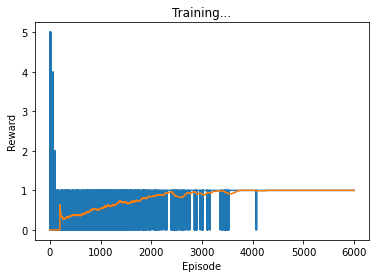

No. of false positives: 0


In [11]:
ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0
dqneplen_list = [min_episode_length for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs))]
dqnloc_count = [0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs))]
#iter_avg_error = [[] for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs))]
#loc_errors = [[] for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)) ]
loc_errors = [0.0 for i in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)) ]
iter_avg_error = []
iter_errors = []

outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
em.env.goal_steps = min_episode_length
for episode in range(episodes):
 
    
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    ep_count = 0
    prevep_bestaction = 0
    
    #changing from LoS to NLoS and viceversa
    #if(episode == 2100):
        #strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 1000)
        #train_steps = 1
    #    em.env.sc_xyz = np.array([[650,300,21.5], [0,-550,21.5]])#np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
    #    em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
    #    em.env.init_ch_model = 'uma-nlos'
        #em.env.goal_steps = min_episode_length
        #max_episode_length = 3
        #print("came here")
    #3if(episode == 3000):
        #strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 1000)
        #train_steps = 1
    #    em.env.sc_xyz = np.array([])#np.array([[650,300,21.5], [0,-550,21.5]])#np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
    #    em.env.ch_model ='uma-los'#'uma-nlos' #free-space path loss model
    #    em.env.init_ch_model = 'uma-los'
    
    #Testing the last 100 episodes
    #if((episode+1) == (episodes-100)):
    #    em.env.goal_steps= min_episode_length
    if ((episode+1) >= (episodes+100)):
        eps = 0.5#strategy.get_exploration_rate(train_steps)
        tx_num = em.env.get_txloc_ndx(np.array([[-100,-100,21.5]]))#*np.cos(58*np.pi/180)
        rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + test_txbdir]
        obs = em.test_reset(np.array([[-100,-100,21.5]]), em.env.sc_xyz, ch_randvals[episode], rbdir_ndx,test_txbdir)
        dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = min_episode_length
        #dqnloc_count[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] +=1
    else:
        eps = 0.5
        obs = em.reset(ch_randvals[episode], episode+1)
        tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
        dqnloc_count[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] +=1
        
    #if (episode ==100):
    #    for tx_loc in em.env.tx_locs:
    #        tx_num = em.env.get_txloc_ndx(tx_loc)
    #        dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = min_episode_length
    #    em.env.goal_steps = min_episode_length
    #    max_episode_length = 3
    
    em.env.goal_steps = dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]
    init_obs = obs
    temp_val = []
    ep_actions = []  
    #rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * self.obs_space.nvec[3] + test_txbdir]
    
    #ep_actions.append(em.env.rbdir_ndx)
    #init_randaction = em.env.rbdir_ndx
    policy_net.eval()
    with torch.no_grad():
        action_probs = policy_net(obs).detach().data.cpu().numpy()[0]  
    policy_net.train()
    actions= np.argsort(action_probs)[::-1]

    em.env.action_list = []
    em.env.action_list.append(em.env.rbdir_ndx)

    selected_actions = []
    selected_actions.append(actions[0])
    ep_actions.append(actions[0])
    
    #Re-collect the previous stored best dqn action for the TXlocation
    #em.env.prev_bestaction#
    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    prevep_bestaction = actions[0]#em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]
    
    #Store the current best dqn action for the episode
    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    #em.env.dqnbestbeam_ndxlist[em.env.tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = actions[0]

    nbour_len = 0
    if (em.env.goal_steps % 2 == 0):
        nbour_len = int((em.env.goal_steps)/2)+1
    else:
        nbour_len = int((em.env.goal_steps)/2)+1
    for i in range(1,nbour_len):
        if ((actions[0]-i) < 0):
            selected_actions.append(em.env.N_rx+actions[0]-i)
            ep_actions.append(em.env.N_rx+actions[0]-i)
        else:
            selected_actions.append(actions[0]-i)
            ep_actions.append(actions[0]-i)
        if((i+1)<nbour_len) or (not(em.env.goal_steps % 2 == 0)):
        #if(len(selected_actions) < (em.env.goal_steps)):
            #if ((actions[0]+i) > (em.env.N_rx-1)):
            #    selected_actions.append(actions[0]+i -em.env.N_rx)
            #    ep_actions.append(actions[0]+i -em.env.N_rx)
            #else:
            selected_actions.append((actions[0]+i) % em.env.N_rx)
            ep_actions.append((actions[0]+i) % em.env.N_rx)
        #else:
        #    selected_actions.append((actions[0]+i) % em.env.N_rx)
        #    ep_actions.append((actions[0]+i) % em.env.N_rx)

    em.env.reward_list = []
    em.env.reward_list.append(float(np.around(1.0, decimals=2)))

    #tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
    #rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
    #data_rates.append(em.env.rate)
    

    memory = ReplayBuffer(available_actions, em.env.goal_steps, em.env.goal_steps, seed, device)
    #memory.memory = em.env.goal_steps
    #memory.batch_size = em.env.goal_steps
    #print("TX Location: {}, Goal steps: {}, init_randaction: {},ep_actions: {}, prevep_bestaction: {}".format(em.env.tx_loc, em.env.goal_steps, init_randaction, ep_actions,prevep_bestaction))
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    temp_actions = []
    temp_rewards = []
    temp_rates = []
    temp_bestrates = []
    rwd_action = -1
    for i in range(len(selected_actions)):
        
        #print(action)
        action = selected_actions[i]
        action = torch.tensor(np.array([action]), dtype=torch.long).to(device)
        next_obs, reward, done, _ = em.step(action)
        if(reward.item() == 1.0):
            rwd_action = action.item()
        em.env.action_list.append(action.item())
        em.env.reward_list.append(float(np.around(reward.item(), decimals=2)))
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)

        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,min_rssi_val,max_rssi_val = em.env.get_minmax_exhrate(ch_randvals[episode])
        
        next_qactionvals = target_net(next_obs).detach().data.cpu().numpy()[0]
        next_qactions= np.argsort(next_qactionvals)[::-1]
        
        next_act = torch.tensor(np.array([next_qactions[0]]), dtype=torch.long).to(device)
        #print("obs: {}, action: {}, reward: {}, next_obs:{}, next_action: {}, done: {}".format(obs, action, reward, next_obs, next_act, done))
        #print("action: {}, reward: {}".format(action, reward))
        temp_actions.append(action.item())
        temp_rewards.append(reward.item())
        temp_rates.append(em.env.rate)
        temp_bestrates.append(em.env.best_rate)
        #print("dqnactionlist: {}, Next qactionvals: {}, next_qactions: {}, selected_nextact:{}".format(agent.dqnaction_list,next_qactionvals, next_qactions, next_act))
        #print(action)
        memory.add(obs, action, reward, next_obs, next_act, done)
        
        #tensors
        #current_qval = policy_net(obs).gather(1,index=action.unsqueeze(-1))
        #next_qval = target_net(next_obs).detach().gather(1,index=next_act.unsqueeze(-1))
        #target_qval = ((next_qval*GAMMA*(~done.unsqueeze(-1))) + reward.unsqueeze(-1))
        #iter_lossval = ALPHA*(target_qval-current_qval)
        #temp_val.append(iter_lossval)
        #print(next_qval)
        obs = next_obs
        timestep +=1
#if memory.can_provide_sample():
    if PRIORITIZED_REPLAY:
        experiences = memory.sample(beta)
        observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
    else:
        experiences = memory.sample()
        observations, actions, rewards, next_observations, next_actions, dones = experiences
        weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

    #print(observations.shape, observations.dtype)
    #print(actions.unsqueeze(-1).shape)
    current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*

    #next_q_values = target_net(next_observations).detach().max(1)[0]
    next_q_values = target_net(next_observations).detach().gather(1,index=next_actions.unsqueeze(-1))#min(1)[0]
    #next_q_actionvals = target_net(next_observations).detach().data.cpu().numpy()[0]
    #next_qactions = np.argsort(next_q_actionvals)[::-1]
    #for i in range(len(next_qactions)):
    #    if next_qactions[i] not in agent.dqnaction_list:

    target_q_values = ((next_q_values*GAMMA*(~dones.unsqueeze(-1))) + rewards.unsqueeze(-1))
    #print(current_q_values.size())
    #print(target_q_values.size())
    #print(dones.unsqueeze(-1).size())
    #print(next_actions.size(), actions.size(), next_q_values.size(), rewards.unsqueeze(-1).size())
    ep_loss = F.mse_loss(current_q_values, target_q_values.float(), reduction='sum')
    #ep_loss = (1-ALPHA)*torch.ones(loss.size()).to(device)+ ALPHA*loss
  #  td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
    #ep_loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.float()-current_q_values),  reduction='sum')
    #loss = F.l1_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
    #loss = F.cross_entropy(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='mean')
    #loss = F.cross_entropy(current_q_values, target_q_values.unsqueeze(1).long(),  reduction='mean')
    #print(target_q_values.float()-current_q_values)
    #weighted_loss = torch.mean(weights*loss)
    #print("loss: ", loss)
    #loss = ALPHA*loss
    #ep_loss += weighted_loss.item()
 #   ep_loss = loss.item()
    #ep_lossval = torch.cat(temp_val, dim=0)
    #print(temp_val, temp_val.size())
    #ep_lossval = torch.tensor(ep_lossarr,dtype=torch.float32).to(device)

    #ep_loss = torch.sum(ep_lossval, dim=0)
    #print(ep_lossval,ep_loss.item())
    #loss = F.mse_loss(torch.zeros(ep_lossval.size()).to(device), ep_lossval, reduction='sum')
    optimizer.zero_grad()
    #weighted_loss.backward()
    ep_loss.backward()
    #loss.backward()
    optimizer.step()

    #if PRIORITIZED_REPLAY:
    #    comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
    #    new_priorities = np.abs(comp_errors) + 1e-6
        #print(new_priorities)
    #    memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)

    #Update the policy network
    if episode % UPDATE_EVERY == 0:
        target_net.load_state_dict(policy_net.state_dict())
    #for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
    #    target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)

    #if memory.can_provide_sample():
    
    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    policy_net.eval()
    with torch.no_grad():
        action_probs = policy_net(init_obs).detach().data.cpu().numpy()[0]  
    policy_net.train()
    bestaction= np.argsort(action_probs)[::-1][0]
    #em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = bestaction
    
    print("TX Location: {}, Goal steps: {}, ep_actions: {}, prevep_bestaction: {}".format(em.env.tx_loc, em.env.goal_steps, ep_actions,prevep_bestaction))
    
    if not(prevep_bestaction == bestaction):
        em.env.goal_steps = min(em.env.goal_steps + episode_delta, max_episode_length)
        dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = em.env.goal_steps
    if (prevep_bestaction == bestaction) and (not(rwd_action == bestaction)):
        print("tx_loc:{} not converged until episode: {}".format(em.env.tx_loc, episode+1))
        
    ep_rewards.append(ep_rwd)
    moving_avg_rwd = get_moving_average(100, ep_rewards)
    #if (ep_rwd > 1.0):
    print('Episode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, current_best action: {}, ep_len: {}, TXloc: {}, ep_loss: {}\n\n'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], bestaction, em.env.rbdir_count, em.env.tx_loc, ep_loss.item()), end="\r")
    
    
    #get the average error between exhaustive and learnt rate for all TXlocations
    #iter_error = Compute_AvgError(em, device, policy_net, ch_randvals[episode])
    #iter_avg_error.append(iter_error)
    rx_bdir =em.env.BeamSet[bestaction]                
    wRF = ula.var_steervec(em.env.N_rx, rx_bdir , 0)
    rssi_val = np.sqrt(em.env.N_rx*em.env.N_tx)*np.array(np.conj(wRF.T).dot(em.env.eff_ch)) #+ (np.conj(wRF.T).dot(self.noise))[0]
    Es = db2lin(em.env.P_tx)  # * (1e-3 / self.B)
    SNR = Es * np.abs(rssi_val) ** 2 / (em.env.N0 * em.env.B)
    dqn_rate = np.log2(1 + SNR)
    
    SNR_exh = Es * np.abs(max_rssi_val) ** 2 / (em.env.N0 * em.env.B)
    error = 10*np.log10(SNR_exh)-10*np.log10(SNR)#max_exh_rate - dqn_rate
    iter_errors.append(error)
    
    tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
    loc_errors[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = error
    iter_avg_error.append(np.mean(loc_errors))

    #loc_errors[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(error)
    #iter_avg_error[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(np.mean(loc_errors[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]))
    #iter_error = Compute_AvgError(em, device, policy_net, ch_randvals[episode])
    #iter_avg_error.append(iter_error)
    timestep = 0
        
            
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')
plot(ep_rewards, 200, test_rewards) 
print("No. of false positives: {}".format(false_positives))

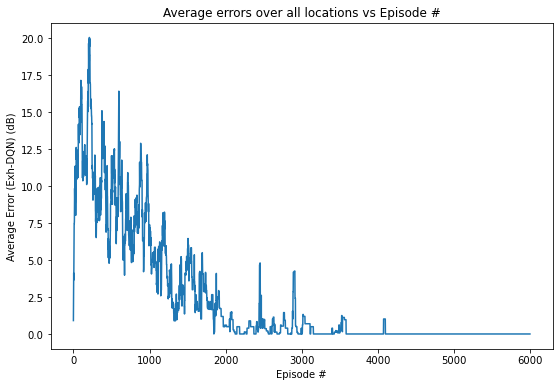

In [18]:
fig=plt.figure(figsize=[9, 6])
min_ndx=0
max_ndx=6000
#for ndx in range(em.env.obs_space.nvec[3] * len(em.env.tx_locs)):
#        plt.plot(loc_errors[ndx][min_ndx:max_ndx])
plt.plot(iter_avg_error[min_ndx:max_ndx])
#plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
#plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('Average Error (Exh-DQN) (dB)')
plt.title('Average errors over all locations vs Episode #')
plt.show()
plt.show()
#print(np.mean(iter_avg_error), len(iter_avg_error))

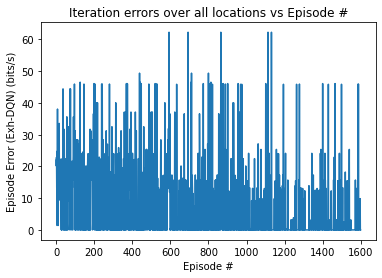

2.3262758996985577 6000


In [13]:
fig=plt.figure()
min_ndx=0
max_ndx=1600
plt.plot(iter_errors[min_ndx:max_ndx])
#plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
#plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('Episode Error (Exh-DQN) (bits/s)')
plt.title('Iteration errors over all locations vs Episode #')
plt.show()
plt.show()
print(np.mean(iter_errors), len(iter_errors))

In [14]:
print(iter_avg_error)

[0.9055831611552335, 1.711002922954017, 2.5988580294203687, 3.133285445857362, 4.122067749536174, 3.6439147638440192, 4.483772158935178, 6.006233699772192, 5.820942316350756, 6.522576512364525, 7.432255488997336, 7.432255488997336, 7.618207855750358, 7.618207855750358, 8.313442821859569, 9.414848043780689, 9.846911070105676, 9.126218973012861, 9.126218973012861, 10.013773334919906, 10.013773334919906, 10.687575132051336, 10.470481044203895, 11.35985619970328, 11.35985619970328, 11.031874848778523, 10.772609047153065, 10.260733002986662, 10.889146931733087, 9.547404928775286, 8.024943387938274, 8.801846754066643, 8.928409549630645, 9.758830803381926, 10.44305454015351, 11.220775230689505, 12.616680247159854, 12.616680247159854, 11.811260485361071, 12.405686083708385, 12.475607087376229, 12.475607087376229, 12.475607087376229, 12.216330380133735, 12.216330380133735, 12.216330380133735, 12.216330380133735, 11.940021620039168, 11.04107697306582, 10.540482367032016, 10.485992631680146, 10.5

In [15]:
a = torch.rand(1, 3, 4)
print(a.shape)
b = torch.rand(3, 4)
print(b.shape)
b = b.unsqueeze(0)
print(b.shape)
c = torch.cat([a, b], dim=0)
print(c.shape)
print(torch.zeros(1,1, dtype=torch.float).size())

torch.Size([1, 3, 4])
torch.Size([3, 4])
torch.Size([1, 3, 4])
torch.Size([2, 3, 4])
torch.Size([1, 1])


In [16]:
print(dqnloc_count)

[263, 211, 221, 233, 253, 270, 253, 232, 238, 241, 257, 222, 232, 225, 234, 215, 273, 229, 246, 234, 228, 240, 237, 256, 257]


In [17]:
#test a particular TXlocation
tx_num = em.env.get_txloc_ndx(np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180)+50,11.5]]))
print(tx_num)
rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + test_txbdir]
obs = em.test_reset(np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180)+50,11.5]]), em.env.sc_xyz, ch_randvals[episode], rbdir_ndx,test_txbdir)
dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = min_episode_length

em.env.goal_steps = dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]
init_obs = obs
temp_val = []
ep_actions = []  
#rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * self.obs_space.nvec[3] + test_txbdir]
#Re-collect the previous stored best dqn action for the TXlocation
#em.env.prev_bestaction#
tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
prevep_bestaction = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx]#em.env.rbdir_ndx
#ep_actions.append(em.env.rbdir_ndx)
init_randaction = em.env.rbdir_ndx
policy_net.eval()
with torch.no_grad():
    action_probs = policy_net(obs).detach().data.cpu().numpy()[0]  
policy_net.train()
actions= np.argsort(action_probs)[::-1]

em.env.action_list = []
em.env.action_list.append(em.env.rbdir_ndx)

selected_actions = []
selected_actions.append(actions[0])
ep_actions.append(actions[0])

#Store the current best dqn action for the episode
tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
em.env.dqnbestbeam_ndxlist[em.env.tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] = actions[0]

nbour_len = 0
if (em.env.goal_steps % 2 == 0):
    nbour_len = int(em.env.goal_steps/2)+1
else:
    nbour_len = int((em.env.goal_steps)/2)+1
for i in range(1,nbour_len):
    if ((actions[0]-i) < 0):
        selected_actions.append(em.env.N_rx+actions[0]-i)
        ep_actions.append(em.env.N_rx+actions[0]-i)
    else:
        selected_actions.append(actions[0]-i)
        ep_actions.append(actions[0]-i)
    if((i+1)<nbour_len) or (not(em.env.goal_steps % 2 == 0)):
        #if ((actions[0]+i) > (em.env.N_rx-1)):
        #    selected_actions.append(actions[0]+i -em.env.N_rx)
        #    ep_actions.append(actions[0]+i -em.env.N_rx)
        #else:
        selected_actions.append((actions[0]+i) % em.env.N_rx)
        ep_actions.append((actions[0]+i) % em.env.N_rx)
    #else:
    #    selected_actions.append((actions[0]+i) % em.env.N_rx)
    #    ep_actions.append((actions[0]+i) % em.env.N_rx)

em.env.reward_list = []
em.env.reward_list.append(float(np.around(1.0, decimals=2)))

tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
data_rates.append(em.env.rate)
print("TX Location: {}, Goal steps: {}, init_randaction: {},ep_actions: {}, prevep_bestaction: {}".format(em.env.tx_loc, em.env.goal_steps, init_randaction, ep_actions,prevep_bestaction))



25


IndexError: list index out of range

In [ ]:
fig=plt.figure()
min_ndx=0
max_ndx=500
plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.show()
print(np.mean(test_eps_iters), len(test_eps_iters))

In [ ]:
print(em.env.ch_model)
print(em.env.sc_xyz)

test_net = QNetwork(state_size, available_actions, seed).to(device)
test_net.load_state_dict(torch.load('checkpoint.pth'))
test_net.eval()
tx_loc = np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
tbdir_ndx = 0
rbdir_ndx = 0
norm_tx_xloc = np.array([(tx_loc[0][0]) / 1000])  # np.max(self.rx_xcov)])#np.array([(self.tx_loc[0][0]+np.max(self.rx_xcov))/(np.max(self.rx_xcov))])#-np.min(self.rx_xcov))])
norm_tx_yloc = np.array([(tx_loc[0][1]) / 1000])  # max(np.max(self.rx_ycov),1)])#np.array([(self.tx_loc[0][1] + np.max(self.rx_ycov)) / (np.max(self.rx_ycov))])# - np.min(self.rx_ycov))])
norm_tx_zloc = np.array([(tx_loc[0][2]) / 22.5])
norm_tx_ndx = np.array([tbdir_ndx / em.env.obs_space.nvec[3]])
norm_rx_ndx = np.array([rbdir_ndx / em.env.action_space.n])
obs = np.array([np.concatenate((norm_rx_ndx, norm_tx_ndx, norm_tx_xloc, norm_tx_yloc,norm_tx_zloc), axis=0)])

obs_tensor = torch.tensor(obs, device=device, dtype=torch.float32)
#print(np.sort(test_net(obs_tensor).data.cpu().numpy()[0]))

In [ ]:
fig = plt.figure(figsize=[9, 6])
min_ndx=24
max_ndx=48
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

In [ ]:
min_ndx=60
max_ndx=80
print(test_data_rates[min_ndx:max_ndx])
print(test_maxexh_rates[min_ndx:max_ndx])
print(em.env.sc_xyz)
print(em.env.ch_model)
print(em.env.init_ch_model)

In [ ]:
print(test_data_rates[69])
print([(x[0]*180/np.pi, x[1]) for x in em.env.BeamSet])
#print(em.env.BeamSet[9])

In [ ]:
print(em.env.dqnobs_counter)
print(len(em.env.dqnobs_counter))
print(np.mean(em.env.dqnobs_counter))

In [ ]:
print(em.env.dqneplen_counter)
print(np.mean(em.env.dqneplen_counter))

In [ ]:
tx_loc = np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
txdir_ndx = 0

tx_num = em.env.get_txloc_ndx(tx_loc)
obs_epiters = em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx]

count = 0
for x,y,z,w in zip(em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx],em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx],em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx], em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx]):
    #print("episode actions: {}, eps: {}".format(x,y,z))
    temp_list =[(i,j,k) for i,j,k in zip(x,z,w)]
    count = count + 1
    if (count >2980):
        print("NLoS episode actions: {}, eps: {}".format(temp_list,y))
    elif (count >=2300 and count <2340):
        print("NLoS-random episode actions: {}, eps: {}".format(temp_list,y))
    
    elif(count > 1990 and count <= 2000):
    #    break
        print("LoS episode actions: {}, eps: {}".format(temp_list,y))
    #else:
    #    pass
    
        
#print(em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx])
#fig = plt.figure(figsize=[9, 6])
#plt.plot(np.arange(len(obs_epiters)), obs_epiters, 'b')
#plt.xlabel('Episode #')
#plt.ylabel('Episode Iterations')
#plt.title('Training convergence for tx_loc:{}, txdir: {}, ep_len:{}'.format(tx_loc, (em.env.BeamSet[txdir_ndx][0]*180/np.pi,em.env.BeamSet[txdir_ndx][1]),em.env.goal_steps))
#plt.show()

In [ ]:
tx_loc = np.array([[-200,-200,21.5]])
txdir_ndx = 0
#print(em.env.BeamSet[5][0]*180/np.pi)
print("tx-loc: ", tx_loc)

em.env.sc_xyz = np.array([[650,300,21.5], [0,-550,21.5]])#[-200,300,21.5], [-200,-300,21.5], [150,-400,21.5], ,[-250,-200,21.5]np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
em.env.init_ch_model = 'uma-nlos'
tx_num = em.env.get_txloc_ndx(tx_loc)
print(em.env.ch_model)
print(em.env.sc_xyz)
for rbdir_ndx in range(8):
    obs = em.test_reset(tx_loc, em.env.sc_xyz, np.exp(1j*2*np.pi*0.6), rbdir_ndx,txdir_ndx)
    #_ = em.env.test_reset(tx_loc, txdir_ndx, rbdir_ndx,em.env.sc_xyz, np.exp(1j * 2 * np.pi * 0.6))
    print("rbdir_ndx: {}, SNR:{}, rate: {}".format(rbdir_ndx, em.env.SNR, em.env.rate))

In [ ]:
tx_loc = np.array([[-200,-200,21.5]])#np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
txdir_ndx = 0

#tx_num = em.env.get_txloc_ndx(tx_loc)
em.env.sc_xyz=np.array([])
em.env.ch_model ='uma-los'#'uma-nlos' #free-space path loss model
em.env.init_ch_model = 'uma-los'
print(em.env.ch_model)
print(em.env.sc_xyz)
for rbdir_ndx in range(8):
    obs = em.test_reset(tx_loc, em.env.sc_xyz, np.exp(1j*2*np.pi*0.6), rbdir_ndx,txdir_ndx)
    #_ = em.env.test_reset(tx_loc, txdir_ndx, rbdir_ndx,em.env.sc_xyz, np.exp(1j * 2 * np.pi * 0.6))
    print("rbdir_ndx: {}, SNR:{}, rate: {}".format(rbdir_ndx, em.env.SNR, em.env.rate))

In [ ]:
print("angle 5: ", em.env.BeamSet[5][0]*180/np.pi)
print("angle 6: ", em.env.BeamSet[6][0]*180/np.pi)
tx_loc = np.array([[-100*np.cos(45*np.pi/180),-100*np.sin(45*np.pi/180),21.5]])
print(tx_loc)

In [ ]:
#import pickle

#memory.save('memory_checkpoint.pth')
plot(ep_rewards, 100, test_rewards)
print(ep_rewards[:100])
moving_avg_rwd = get_moving_average(100, ep_rewards[:100])
print(moving_avg_rwd)

## Test the DQN agent

In [ ]:
from Source.misc_fun.utils import var_plotbeam

print(tx_dirs)
print(rx_dirs)
for tx_ang, rx_ang in zip(tx_dirs, rx_dirs):
    tx_theta, tx_gr = var_plotbeam(tx_ang, em.env.N_tx)
    rx_theta, rx_gr = var_plotbeam(rx_ang, em.env.N_rx)
    ax1 = plt.subplot(122, projection='polar')
    ax1.plot(tx_theta, tx_gr)

    ax2 = plt.subplot(121, projection='polar')
    ax2.plot(rx_theta, rx_gr)

    plt.show()




## Display all exhaustive rate measurements from env

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

fig = plt.figure()
ax = fig.gca(projection='3d')
poly = PolyCollection(verts[:4], facecolors=['r', 'g', 'b', 'y'], alpha=0.6)
print(len(verts))
print(verts[0:2])
#print(np.array(tx_locs[:4]))
ax.add_collection3d(poly, zs=np.arange(1,5), zdir='y')

ax.set_xlabel('X (beam pairs)')
ax.set_ylabel('Y (tx_locs)')
ax.set_zlabel('Z (data rates)')
ax.set_xlim(0, 10)
ax.set_ylim(1, 5)
ax.set_zlim(10, 30)

plt.show()

from Source.misc_fun.utils import plotbeam

tx_theta, tx_gr = plotbeam(exh_txbeams[0]*(np.pi/180), em.env.N_tx)
rx_theta, rx_gr = plotbeam(exh_rxbeams[0]*(np.pi/180), em.env.N_rx)
ax1 = plt.subplot(122, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(121, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()

